In [1]:
import collections 
import math 
import os 
import shutil 
import pandas as pd 
import torch 
import torchvision 
from torch import nn 
from d2l import torch as d2l 
import matplotlib.pyplot as plt 
import numpy as np
import random
import time
import tqdm

In [2]:
torch.cuda.is_available()
torch.cuda.device_count()

1

In [3]:
# 如果使用测试数据：
# d2l.DATA_HUB['dog_tiny'] = (d2l.DATA_URL + 'kaggle_dog_tiny.zip',
#                             '0cb91d09b814ecdc07b50f31f8dcad3e81d6a86d'
demo = False 
if demo:
    data_dir = d2l.download_extract('dog_tiny')
else:
    data_dir = os.path.join('data', 'dog-breed-identification')


In [4]:
def read_csv_label(fname):
    """读取CSV格式的标签文件。"""
    with open(fname, 'r') as f:
        # 跳过文件头行（栏名称）
        lines = f.readlines()[1:]
        tokens = [l.rstrip().split(',') for l in lines]
        # 将ID和标签分开
        return dict(((id, label) for id, label in tokens))
labels = read_csv_label(os.path.join(data_dir, 'labels.csv'))
labels

{'000bec180eb18c7604dcecc8fe0dba07': 'boston_bull',
 '001513dfcb2ffafc82cccf4d8bbaba97': 'dingo',
 '001cdf01b096e06d78e9e5112d419397': 'pekinese',
 '00214f311d5d2247d5dfe4fe24b2303d': 'bluetick',
 '0021f9ceb3235effd7fcde7f7538ed62': 'golden_retriever',
 '002211c81b498ef88e1b40b9abf84e1d': 'bedlington_terrier',
 '00290d3e1fdd27226ba27a8ce248ce85': 'bedlington_terrier',
 '002a283a315af96eaea0e28e7163b21b': 'borzoi',
 '003df8b8a8b05244b1d920bb6cf451f9': 'basenji',
 '0042188c895a2f14ef64a918ed9c7b64': 'scottish_deerhound',
 '004396df1acd0f1247b740ca2b14616e': 'shetland_sheepdog',
 '0067dc3eab0b3c3ef0439477624d85d6': 'walker_hound',
 '00693b8bc2470375cc744a6391d397ec': 'maltese_dog',
 '006cc3ddb9dc1bd827479569fcdc52dc': 'bluetick',
 '0075dc49dab4024d12fafe67074d8a81': 'norfolk_terrier',
 '00792e341f3c6eb33663e415d0715370': 'african_hunting_dog',
 '007b5a16db9d9ff9d7ad39982703e429': 'wire-haired_fox_terrier',
 '007b8a07882822475a4ce6581e70b1f8': 'redbone',
 '007ff9a78eba2aebb558afea3a51c469'

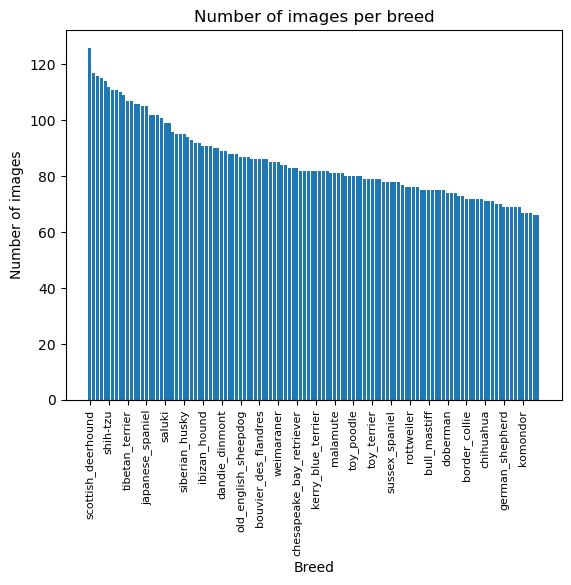

+-----+--------------------------------+--------------------+
|     | Breed                          |   Number of images |
|-----+--------------------------------+--------------------|
|   0 | scottish_deerhound             |                126 |
|   1 | maltese_dog                    |                117 |
|   2 | afghan_hound                   |                116 |
|   3 | entlebucher                    |                115 |
|   4 | bernese_mountain_dog           |                114 |
|   5 | shih-tzu                       |                112 |
|   6 | great_pyrenees                 |                111 |
|   7 | pomeranian                     |                111 |
|   8 | basenji                        |                110 |
|   9 | samoyed                        |                109 |
|  10 | tibetan_terrier                |                107 |
|  11 | airedale                       |                107 |
|  12 | cairn                          |                106 |
|  13 | 

In [5]:
df = pd.read_csv(os.path.join(data_dir, 'labels.csv'))
counts = df['breed'].value_counts()
plt.bar(counts.index, counts.values)
plt.xticks([counts.index[i] for i in range(0,len(counts),5)], rotation = 90 ,fontsize=8)
plt.title('Number of images per breed')
plt.xlabel('Breed')
plt.ylabel('Number of images')
plt.show()

table = pd.DataFrame({'Breed': counts.index, 'Number of images': counts.values})
import tabulate
print(tabulate.tabulate(table, headers='keys', tablefmt='psql'))

In [4]:
# 数据分为训练数据集、验证数据集、测试数据集，并分别复制到对应的文件夹之中
"""如果数据量不大（对于我个人的主机，几个G的数据还是可以这样做），但是数据太大就不建议了，这样数据会被复制两次"""
def reorg_dog_data(data_dir, valid_ratio):
    labels = d2l.read_csv_labels(os.path.join(data_dir, 'labels.csv'))
    d2l.reorg_train_valid(data_dir, labels, valid_ratio)
    d2l.reorg_test(data_dir)

batch_size = 32 if demo else 128
valid_ratio = 0.1
reorg_dog_data(data_dir, valid_ratio)


In [6]:
transform_train = torchvision.transforms.Compose([
    # 随机裁剪图像，所得图像为原始面积的0.08到1之间，高宽比在3/4和4/3之间。
    # 然后，缩放图像以创建224 x 224的新图像
    torchvision.transforms.RandomResizedCrop(224, scale=(0.08, 1.0),
                                             ratio=(3.0 / 4.0, 4.0 / 3.0)),
    torchvision.transforms.RandomHorizontalFlip(),
    # 随机更改亮度，对比度和饱和度
    torchvision.transforms.ColorJitter(brightness=0.4, contrast=0.4,
                                       saturation=0.4),
    # 添加随机噪声
    torchvision.transforms.ToTensor(),
    # 标准化图像的每个通道
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])

transform_test = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    # 从图像中心裁切224x224大小的图片
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])])


In [7]:
# 注意四个datasets:train_valid_ds 是train_ds和valid_ds的集合（通常我们是根据这个数据集来划分train和valid的）
train_ds, train_valid_ds = [
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train_valid_test', folder),
        transform=transform_train) for folder in ['train', 'train_valid']]

valid_ds, test_ds = [
    torchvision.datasets.ImageFolder(
        os.path.join(data_dir, 'train_valid_test', folder),
        transform=transform_test) for folder in ['valid', 'test']]


In [8]:
train_iter, train_valid_iter = [torch.utils.data.DataLoader(
    dataset, batch_size, shuffle=True, drop_last=True)
    for dataset in (train_ds, train_valid_ds)]

valid_iter = torch.utils.data.DataLoader(valid_ds, batch_size, shuffle=False,
                                         drop_last=True)

test_iter = torch.utils.data.DataLoader(test_ds, batch_size, shuffle=False,
                                        drop_last=False)


torch.Size([128, 3, 224, 224]) torch.Size([128])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


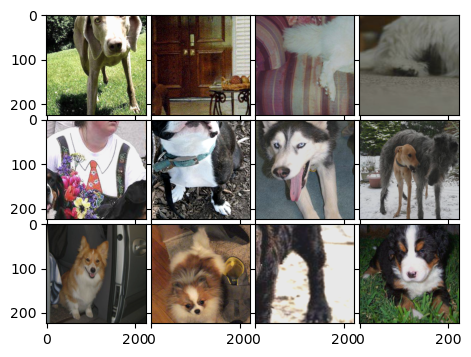

In [9]:
from mpl_toolkits.axes_grid1 import ImageGrid
def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    axis.imshow(inp)
    
img, label = next(iter(train_iter))
print(img.size(), label.size())
fig = plt.figure(1, figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 4), axes_pad=0.05)    
for i in range(12):
    ax = grid[i]
    img_data = img[i]
    imshow(ax, img_data)


In [ ]:
# use pre_trained model to extract features from dataset, return a list of features and labels
def extract_features(model_name, data_iter, device):
    model = getattr(torch.models, model_name)(pretrained=True)
    feature_extractor = nn.Sequential(*list(model.children())[:-1])
    feature_extractor.to(device)
    feature_extractor.eval()
    features = []
    labels = []
    for X, y in data_iter:
        X = X.to(device)
        with torch.no_grad():
            feature = feature_extractor(X).cpu()
        features.append(feature)
        labels.append(y)
    return torch.cat(features), torch.cat(labels)

In [ ]:
# use pre_trained model to extract features from dataset
model_names = ['resnet101','inception_v3','densenet161']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# resnet101_features_train, resnet101_labels_train = extract_features(model_names[0], train_iter, device)
# inception_v3_features_train, inception_v3_labels_train = extract_features(model_names[1], train_iter, device)
# densenet161_features_train, densenet161_labels_train = extract_features(model_names[2], train_iter, device)

# resnet101_features_valid, resnet101_labels_valid = extract_features(model_names[0], valid_iter, device)
# inception_v3_features_valid, inception_v3_labels_valid = extract_features(model_names[1], valid_iter, device)
# densenet161_features_valid, densenet161_labels_valid = extract_features(model_names[2], valid_iter, device)

resnet101_features_train, resnet101_labels_train = extract_features(model_names[0], train_valid_iter, device)
inception_v3_features_train, inception_v3_labels_train = extract_features(model_names[1], train_valid_iter, device)
densenet161_features_train, densenet161_labels_train = extract_features(model_names[2], train_valid_iter, device)



resnet101_features_test, resnet101_labels_test = extract_features(model_names[0], test_iter, device)
inception_v3_features_test, inception_v3_labels_test = extract_features(model_names[1], test_iter, device)
densenet161_features_test, densenet161_labels_test = extract_features(model_names[2], test_iter, device)


# create features folder and save features
os.makedirs('./features', exist_ok=True)
torch.save(resnet101_features_train, './features/resnet101_features.pt')
torch.save(inception_v3_features_train, './features/inception_v3_features.pt')
torch.save(densenet161_features_train, './features/densenet161_features.pt')


# concatenate features from different models
final_features = torch.cat((resnet101_features_train, inception_v3_features_train, densenet161_features_train), dim=1)
print('Final features shape:', final_features.shape)

In [ ]:
# create a dnn model take features as input
class DNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(DNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.softmax(x)
        return x

In [ ]:
loss = nn.CrossEntropyLoss(reduction='none')
def evaluate_loss(data_iter, net, devices):
    l_sum, n = 0.0, 0
    for features, labels in data_iter:
        features, labels = features.to(devices[0]), labels.to(devices[0])
        outputs = net(features)
        l = loss(outputs, labels)
        l_sum += l.sum()
        n += labels.numel()
    return l_sum / n

In [ ]:
def train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,
          lr_decay):

    # 只训练小型自定义输出网络
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    # 注意这里进行训练的部分是都可以求解梯度的部分（即我们自定义的部分）
    trainer = torch.optim.adam(
        (param for param in net.parameters() if param.requires_grad), lr=lr,
        momentum=0.9, weight_decay=wd)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_period, lr_decay)
    num_batches, timer = len(train_iter), d2l.Timer()
    legend = ['train loss']
    if valid_iter is not None:
        legend.append('valid loss')
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs],
                            legend=legend)
    for epoch in range(num_epochs):
        metric = d2l.Accumulator(2)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            features, labels = features.to(devices[0]), labels.to(devices[0])
            trainer.zero_grad()
            output = net(features)
            l = loss(output, labels).sum()
            l.backward()
            trainer.step()
            metric.add(l, labels.shape[0])
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[1], None))
        measures = f'train loss {metric[0] / metric[1]:.3f}'
        if valid_iter is not None:
            valid_loss = evaluate_loss(valid_iter, net, devices)
            animator.add(epoch + 1, (None, valid_loss.cpu().detach()))
        scheduler.step()
    if valid_iter is not None:
        measures += f', valid loss {valid_loss:.3f}'
    print(measures + f'\n{metric[1] * num_epochs / timer.sum():.1f}'
          f' examples/sec on {str(devices)}')


In [ ]:
net = DNN(final_features.shape[1], 256, 120)
devices, num_epochs, lr, wd = d2l.try_all_gpus(), 20, 1e-4, 1e-4
lr_period, lr_decay = 2, 0.75
train(net, train_iter, valid_iter, num_epochs, lr, wd, devices, lr_period,lr_decay)

In [ ]:
# test the model
train(net, train_valid_iter, None, num_epochs, lr, wd, devices[0])

pred = []
for X, y in test_iter:
    X = X.to(devices[0])
    y_hat = net(X)
    pred.extend(y_hat.argmax(dim=1).cpu().numpy())
pred = np.array(pred)
# print('Test accuracy:', (pred == test_labels).sum() / len(test_labels))


In [17]:
def visualize_model(valid_iter, net, devices, num_images=16):
    cnt = 0
    fig = plt.figure(1, figsize=(16, 16))
    grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.05)
    net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    for i, (inputs, labels) in enumerate(valid_iter):
        outputs = net(inputs.to(devices[0]))
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            ax = grid[cnt]
            imshow(ax, inputs.cpu().data[j])
            ax.text(10, 210, '{}/{}'.format(preds[j], labels.data[j]), 
                    color='k', backgroundcolor='w', alpha=0.8)
            cnt += 1
            if cnt == num_images:
                return

visualize_model(valid_iter,net ,devices)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

In [ ]:
net = get_net(devices)
train(net, train_valid_iter, None, num_epochs, lr, wd, devices, lr_period,lr_decay)

preds = []
for data, label in test_iter:
    output = torch.nn.functional.softmax(net(data.to(devices[0])), dim=0)
    preds.extend(output.cpu().detach().numpy())
ids = sorted(
    os.listdir(os.path.join(data_dir, 'train_valid_test', 'test', 'unknown')))
with open('./kaggle_submission/dog/submission4.csv', 'w') as f:
    f.write('id,' + ','.join(train_valid_ds.classes) + '\n')
    for i, output in zip(ids, preds):
        f.write(
            i.split('.')[0] + ',' + ','.join([str(num)
                                              for num in output]) + '\n')
